In [1]:
%cd ../src

/home/ubuntu/SPVD_Lightning/src


In [2]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [3]:
model_args = {
    'voxel_size' : 0.1,
    'nfs' : (32, 64, 128, 256), 
    'attn_chans' : 8, 
    'attn_start' : 3, 
    'cross_attn_chans' : 8, 
    'cross_attn_start' : 2, 
    'cross_attn_cond_dim' : 768,
}

model = SPVUnet(**model_args)
model = GSPVD(model=model, lr=0.1, training_steps=1)

In [4]:
from dataloaders.shapenet.shapenet_loader import ShapeNet

categories = ['car']
path = "../data/ShapeNet"

te = ShapeNet(path, "test", 2048, categories, load_renders=True)

Loading (test) renders for car (02958343): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:02<00:00, 347.49it/s]


In [5]:
import numpy as np

samples = 16
references = [te[idx] for idx in np.random.choice(list(range(len(te))), size=(samples,))]

reference_images = torch.stack([r["render-features"] for r in references]).to("cuda")

In [6]:
steps = 1000
scheduler = 'ddpm'
ckpt_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/{steps}-steps.ckpt'
ckpt = torch.load(ckpt_path, weights_only=False)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [7]:
model = model.cuda().eval()

In [8]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
from my_schedulers.ddim_scheduler import DDIMSparseScheduler
from utils.visualization import display_pointclouds_grid

if scheduler == 'ddim':
    sched = DDIMSparseScheduler(beta_min=0.0001, beta_max=0.02, steps=steps, init_steps=1000)
else:
    sched = DDPMSparseScheduler(beta_min=0.0001, beta_max=0.02, steps=steps, init_steps=1000)

In [9]:
preds = sched.sample(model, samples, 2048, reference=reference_images)

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.66it/s]


In [10]:
display_pointclouds_grid(preds.cpu().numpy(), offset=8, point_size=0.3)

Output()

In [11]:
real = torch.stack([r["pc"] for r in references]).numpy()
display_pointclouds_grid(real, offset=8, point_size=0.3)

Output()

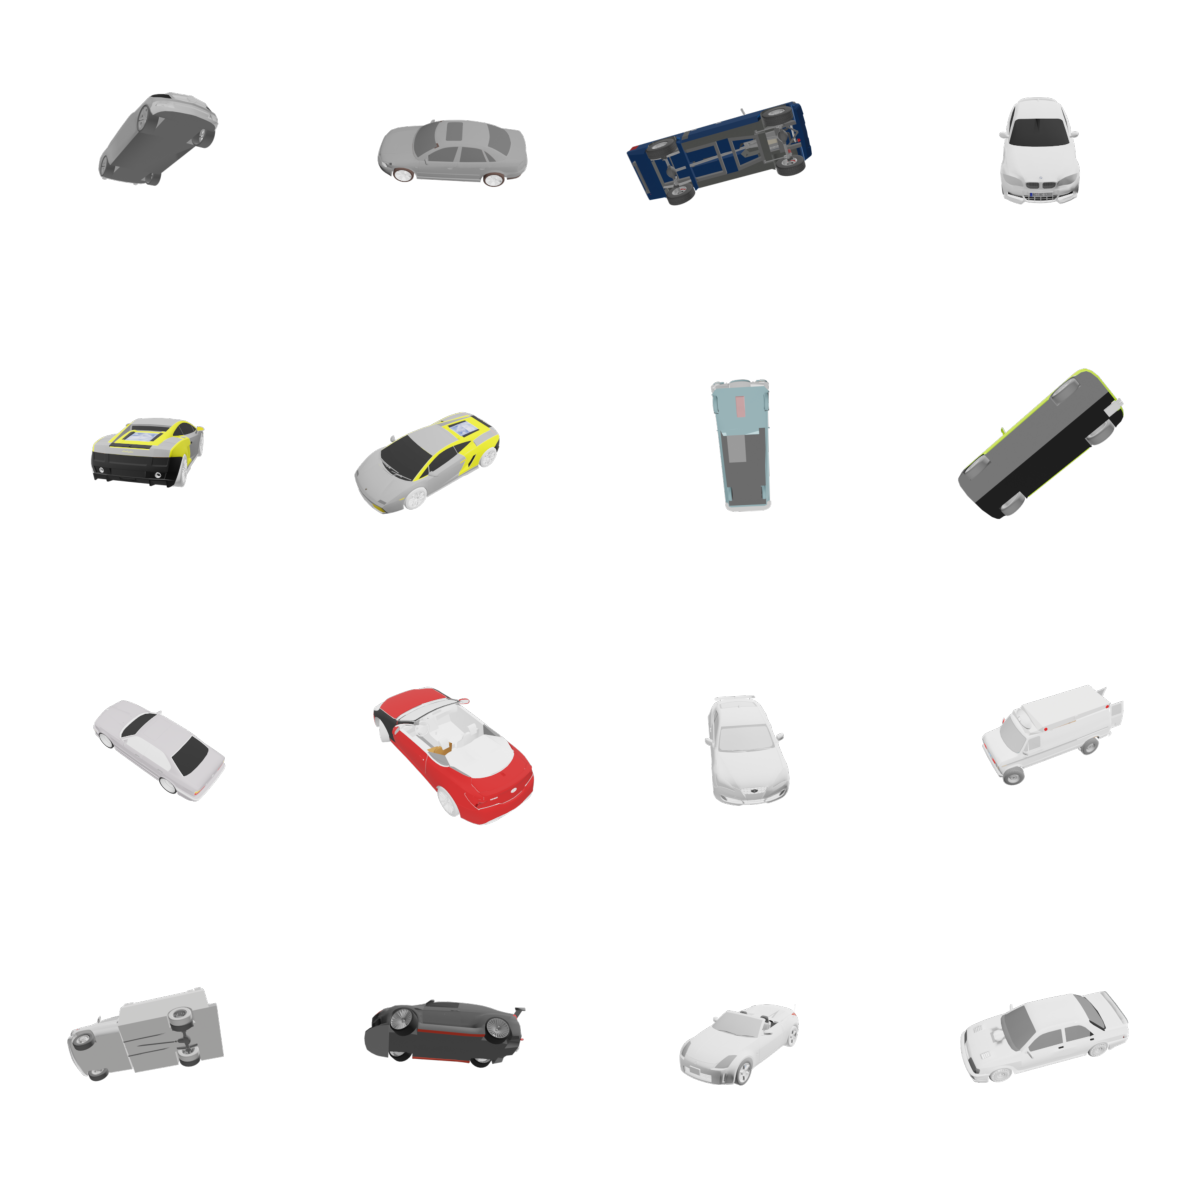

In [12]:
from utils.visualization import display_renders_grid

def load_image(selected_file, selected_view):
    from PIL import Image
    return np.array(Image.open("../data/ShapeNet/renders/" + selected_file + f"/00{selected_view}.png"))

renders = np.stack([load_image(r['filename'], r['selected-view']) for r in references])
display_renders_grid(renders)